In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn as sns
import urllib as url
import json
from scipy.stats import pearsonr
from pysal.model.spint.gravity import *
%pylab inline

import scipy.stats as st

//anaconda/envs/spacegan/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read station data and select stations with nonzero capacity
'''
stations = url.request.urlopen('http://citibikenyc.com/stations/json').read()
stations = json.loads(stations)
station = tuple(station['id'] for station in stations['stationBeanList'])
capacity = tuple(station['totalDocks'] for station in stations['stationBeanList'])
latitude = tuple(station['latitude'] for station in stations['stationBeanList'])
longitude = tuple(station['longitude'] for station in stations['stationBeanList'])
testStation = tuple(station['testStation'] for station in stations['stationBeanList'])
statusValue = tuple(station['statusValue'] for station in stations['stationBeanList'])
station_info = {'station':station, 'capacity':capacity, 'latitude':latitude, 'longitude':longitude, 'testStation':testStation, 'statusValue':statusValue}
station_info = pd.DataFrame(station_info)
station_info = station_info[station_info['capacity'] > 0]

# Save a data locally because the URL is synchronous 
station_info.to_csv('stations_info.csv')
'''

"\nstations = url.request.urlopen('http://citibikenyc.com/stations/json').read()\nstations = json.loads(stations)\nstation = tuple(station['id'] for station in stations['stationBeanList'])\ncapacity = tuple(station['totalDocks'] for station in stations['stationBeanList'])\nlatitude = tuple(station['latitude'] for station in stations['stationBeanList'])\nlongitude = tuple(station['longitude'] for station in stations['stationBeanList'])\ntestStation = tuple(station['testStation'] for station in stations['stationBeanList'])\nstatusValue = tuple(station['statusValue'] for station in stations['stationBeanList'])\nstation_info = {'station':station, 'capacity':capacity, 'latitude':latitude, 'longitude':longitude, 'testStation':testStation, 'statusValue':statusValue}\nstation_info = pd.DataFrame(station_info)\nstation_info = station_info[station_info['capacity'] > 0]\n\n# Save a data locally because the URL is synchronous \nstation_info.to_csv('stations_info.csv')\n"

In [4]:
# set coordinate reference system, read New York City boundary, and set reference system
boros = gp.read_file('/Users/toshan/Dropbox/Dissertation/data_collection/nyc_boundaries/nybb_16d/nybb.shp')
boros = boros.to_crs(crs='epsg:4326')

<AxesSubplot:>

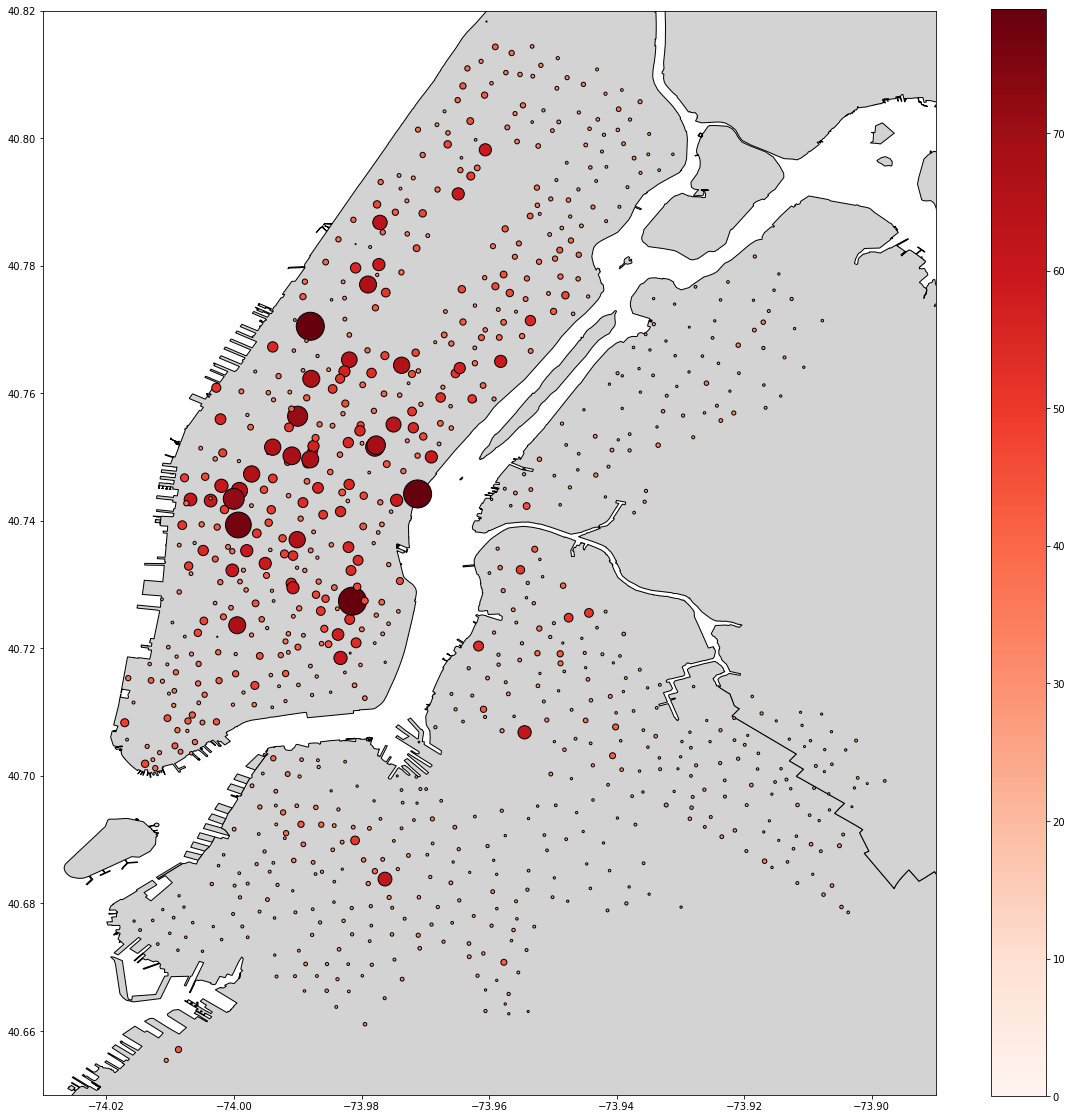

In [5]:
#Read station data if it is saved locally
station_info = pd.read_csv('stations_info.csv')

#select only nyc stations and plot
station_info['geometry'] = station_info.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
station_points = gp.GeoDataFrame(station_info, geometry='geometry')

within = station_points.apply(lambda x: boros.contains(x.geometry).any(), axis=1)
station_points = station_points[within]

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xlim(-74.03, -73.89)
ax.set_ylim(40.65, 40.82)
boros.plot(ax=ax, facecolor='lightgrey', edgecolor='black')
size = np.exp((station_points['capacity'].astype(float)+1.0)/12.0)
station_points.plot('capacity', ax=ax, cmap='Reds', markersize=size, legend=True, edgecolor='black')

In [6]:
# Read the bike trip data
trips = pd.read_csv('https://s3.amazonaws.com/tripdata/201906-citibike-tripdata.csv.zip')

In [7]:
# Number of trips
len(trips)

2125370

In [1072]:
#aggregate trip data to stations

agg = trips.groupby(['start station id', 'end station id']).agg({'gender':'count','tripduration':mean})
agg.rename(columns={'gender':'count'}, inplace=True)
agg.reset_index(inplace=True)

In [1073]:
#merge in station capacity city

temp = pd.merge(agg, station_info, left_on='start station id', right_on='station')
temp.rename(columns={'capacity':'o_cap'}, inplace=True)
temp = pd.merge(temp, station_info, left_on='end station id', right_on='station')
temp.rename(columns={'capacity':'d_cap'}, inplace=True)
agg2 = temp[['start station id', 'end station id', 'tripduration', 'o_cap', 'd_cap', 'count']]

In [1074]:
#check for stations with zero capacity

agg2[agg2['d_cap']==0]['end station id'].unique()

array([3162])

In [1075]:
#filter out stations with zero capacity

agg2 = agg2[(agg2['d_cap']!=0) & (agg2['o_cap']!=0)]

In [1076]:
#fit production-constrained model

flows = agg2['count'].values.reshape((-1,1))
origins = agg2['start station id'].values.reshape((-1,1))
destinations = agg2['d_cap'].values.reshape((-1,1))
cost = agg2['tripduration'].values.reshape((-1,1))

model1 = Production(flows, origins, destinations, cost, cost_func='pow').fit()

In [1077]:
model1.pseudoR2

0.4416061664913804

In [1078]:
#parameter estimates

model1.params[-2:]

array([ 0.54304169, -1.39734179])

# Scenario 1 - Increase capacity of station 445

In [834]:
# View original destination station 445 capacity
agg2[(agg2['end station id'] == 445)]

,start station id,end station id,tripduration,o_cap,d_cap,count
37035,72,445,2679.000000,55,79,1
37036,79,445,1213.857143,33,79,7
37037,82,445,66888.285714,27,79,7
37038,116,445,905.883721,50,79,43
37039,120,445,1765.000000,19,79,1
...,...,...,...,...,...,...
37423,3768,445,2050.000000,23,79,3
37424,3772,445,1858.000000,19,79,1
37425,3773,445,1555.000000,20,79,1
37426,3781,445,1684.000000,30,79,1


In [835]:
# Calculate initial Oi/Ai values from observed data

#Recompute Ai
if 'ai' in agg2.columns:
    agg2.drop('ai', axis=1, inplace=True)
if 'Ai' in agg2.columns:
    agg2.drop('Ai', axis=1, inplace=True)
agg2['ai'] = (agg2['d_cap']**0.54304169)*(agg2['tripduration']**-1.39734179)
ai = agg2.groupby('start station id').agg({'ai':'sum'})
ai.reset_index(inplace=True)
ai.rename(columns={'ai':'Ai'}, inplace=True)
agg2 = pd.merge(agg2, ai, left_on='start station id', right_on='start station id')

#to use multiplicative production constrained model equation, need to compute O_i
if 'Oi' in agg2.columns:
    agg2.drop('Oi', axis=1, inplace=True)
oi = agg2.groupby('start station id').agg({'count':'sum'})
oi.reset_index(inplace=True)
oi.rename(columns={'count':'Oi'}, inplace=True)
#oi = oi.append({'start station id':445, 'Oi':20165}, ignore_index=True)
agg2 = pd.merge(agg2, oi, left_on='start station id', right_on='start station id')


In [836]:
# Set destination station capacity to 150
agg2['d_cap'][(agg2['end station id'] == 445)] = 150

In [986]:
# View changes
agg2[(agg2['end station id'] == 445)]

,start station id,end station id,tripduration,o_cap,d_cap,count,test_flows,ai,Ai,Oi
108,72,445,2679.000000,55,79,1,6.880664,0.000173,0.119126,4751
428,79,445,1213.857143,33,79,7,10.342576,0.000521,0.144988,2879
738,116,445,905.883721,50,79,43,28.182149,0.000784,0.183854,6612
1103,127,445,951.631579,31,79,38,28.863124,0.000732,0.158665,6260
1447,128,445,1206.771429,30,79,35,20.964156,0.000525,0.175143,6992
...,...,...,...,...,...,...,...,...,...,...
180859,3527,445,2620.000000,27,79,1,1.820671,0.000178,0.060605,620
183284,436,445,2426.500000,27,79,2,2.182840,0.000198,0.077862,858
184117,3591,445,1972.000000,21,79,1,3.021925,0.000265,0.063567,726
184419,3772,445,1858.000000,19,79,1,1.907669,0.000288,0.069181,459


In [838]:
agg2['pred_flows'] = agg2['Ai']**-1*agg2['Oi']*(agg2['d_cap']**0.54304169)*(agg2['tripduration']**-1.39734179)

In [839]:
# difference between total predicted and observed flows (without rebalancing)
agg2['pred_flows'].sum() - agg2['count'].sum()

2856.535214123316

In [840]:
# Predicted inflows from increasing capacity and observed inflows (without rebalancing)
agg2[agg2['end station id'] == 445]['pred_flows'].sum(), agg2[agg2['end station id'] == 445]['count'].sum()

(9714.905448436837, 7789)

In [841]:
#the additional inflow trips due to increased destination capacity for stations 445(without rebalancing)

agg2[agg2['end station id'] == 445]['pred_flows'].sum() - agg2[agg2['end station id'] == 445]['count'].sum()

1925.905448436837

In [842]:
#the additional inflow trips due to differences in balancing factors
agg2[agg2['end station id'] != 445]['pred_flows'].sum() - agg2[agg2['end station id'] != 445]['count'].sum()

930.629765686579

In [843]:
#Total difference is composed of addition inflow at 445 plus difference b/w method inflow at all other stations

In [844]:
#Now lets see the difference when we do rebalance

In [845]:
#Recompute Ai
if 'ai' in agg2.columns:
    agg2.drop('ai', axis=1, inplace=True)
if 'Ai' in agg2.columns:
    agg2.drop('Ai', axis=1, inplace=True)
agg2['ai'] = (agg2['d_cap']**0.54304169)*(agg2['tripduration']**-1.39734179)
ai = agg2.groupby('start station id').agg({'ai':'sum'})
ai.reset_index(inplace=True)
ai.rename(columns={'ai':'Ai'}, inplace=True)
agg2 = pd.merge(agg2, ai, left_on='start station id', right_on='start station id')

#to use multiplicative production constrained model equation, need to compute O_i
if 'Oi' in agg2.columns:
    agg2.drop('Oi', axis=1, inplace=True)
oi = agg2.groupby('start station id').agg({'count':'sum'})
oi.reset_index(inplace=True)
oi.rename(columns={'count':'Oi'}, inplace=True)
#oi = oi.append({'start station id':445, 'Oi':20165}, ignore_index=True)
agg2 = pd.merge(agg2, oi, left_on='start station id', right_on='start station id')


In [846]:
agg2['pred_flows'] = agg2['Ai']**-1*agg2['Oi']*(agg2['d_cap']**0.54304169)*(agg2['tripduration']**-1.39734179)

In [847]:
# total predicted and observed flows with rebalancing
agg2['pred_flows'].sum() - agg2['count'].sum()

0.0

In [848]:
# difference between Predicted inflows From increasing capacity and observed inflows
agg2[agg2['end station id'] == 445]['pred_flows'].sum(), agg2[agg2['end station id'] == 445]['count'].sum()

(9688.889667108924, 7789)

In [849]:
# total difference
agg2[agg2['end station id'] == 445]['pred_flows'].sum() - agg2[agg2['end station id'] == 445]['count'].sum()

1899.8896671089242

In [850]:
# however, since we hold to the number of total trips constant 
#the additional inflow trips due to increased destination capacity Must come from the other stations
agg2[agg2['end station id'] != 445]['pred_flows'].sum() - agg2[agg2['end station id'] != 445]['count'].sum()

-1899.8896671093535

In [851]:
#The same is not true here since we rebalance Ai

# Scenario 2 - add new station (remove a known station and use it to validate)

In [1039]:
#select a large station to make some test predictions

test = station_points[station_points['station'] == 445]

<AxesSubplot:>

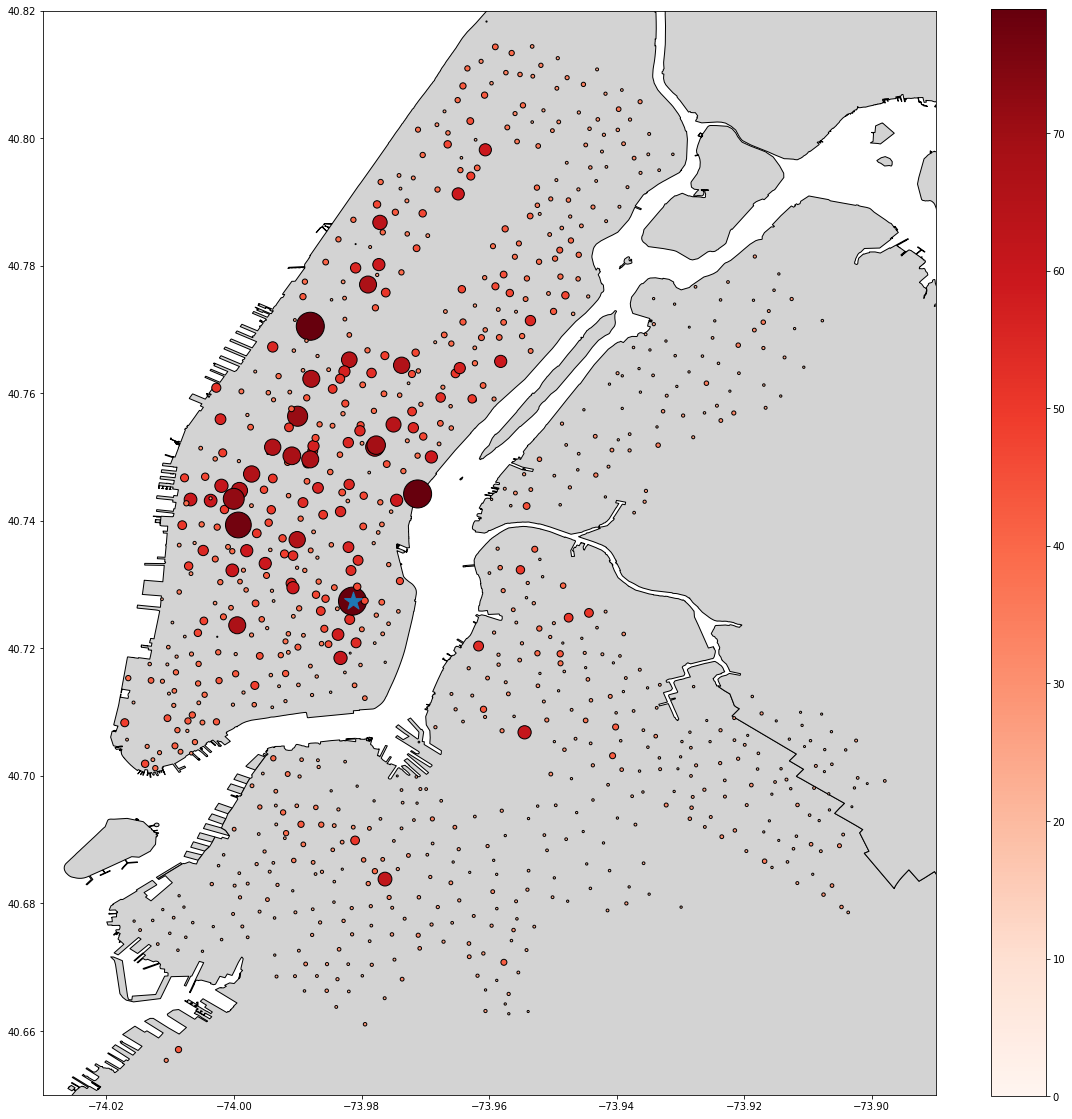

In [1040]:
#plot selected station

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xlim(-74.03, -73.89)
ax.set_ylim(40.65, 40.82)
boros.plot(ax=ax, facecolor='lightgrey', edgecolor='black')
station_points.plot('capacity', ax=ax, cmap='Reds', markersize=np.exp((station_points['capacity'].astype(float)+1.0)/12.0), legend=True, edgecolor='black')
test.plot(ax=ax, marker='*', markersize=350)

In [1041]:
#save observed inflows & outflows for station 445

obs_outflows = agg2[agg2['start station id'] == 445]
obs_inflows = agg2[agg2['end station id'] == 445]

In [1042]:
#select flows that exclude station 445

agg_subset = agg2[(agg2['start station id'] != 445) & (agg2['end station id'] != 445)]

In [1043]:
#calibrate production constrained model w/o station 445 data
flows = agg_subset['count'].values.reshape((-1,1))
origins = agg_subset['start station id'].values.reshape((-1,1))
destinations = agg_subset['d_cap'].values.reshape((-1,1))
cost = agg_subset['tripduration'].values.reshape((-1,1))

model2 = Production(flows, origins, destinations, cost, cost_func='pow').fit()

In [1044]:
(model2.yhat.sum() - agg_subset['count'].sum())

13.290617028949782

In [1045]:
model2.pseudoR2

0.4401199563492022

In [1046]:
model2.params[-2:]

array([ 0.53829042, -1.39575897])

In [1081]:
#make predictions for all stations including 445 using agg2 because it has d_cap and duration data setup for 445
# but use params from model2 that omits station 445

#key is that we need to specify a value of Oi for 445

#to use multiplicative production constrained model equation, need to compute A_i
if 'ai' in agg2.columns:
    agg2.drop('ai', axis=1, inplace=True)
if 'Ai' in agg2.columns:
    agg2.drop('Ai', axis=1, inplace=True)
agg2['ai'] = (agg2['d_cap']**0.53829042)*(agg2['tripduration']**-1.39575897)
ai = agg2.groupby('start station id').agg({'ai':'sum'})
ai.reset_index(inplace=True)
ai.rename(columns={'ai':'Ai'}, inplace=True)
agg2 = pd.merge(agg2, ai, left_on='start station id', right_on='start station id')

#to use multiplicative production constrained model equation, need to compute O_i
if 'Oi' in agg2.columns:
    agg2.drop('Oi', axis=1, inplace=True)
oi = agg_subset.groupby('start station id').agg({'count':'sum'})
oi.reset_index(inplace=True)
oi.rename(columns={'count':'Oi'}, inplace=True)
oi = oi.append({'start station id':445, 'Oi':7191}, ignore_index=True)
agg2 = pd.merge(agg2, oi, left_on='start station id', right_on='start station id')

#use multiplicative production constrained model equation to predict
agg2['test_flows'] = (agg2['Ai'])**-1*agg2['Oi']*(agg2['d_cap']**0.53829042)*(agg2['tripduration']**-1.39575897)

In [1085]:
# difference between total predicted and total observed flows (because we lost flows ending at 445)

(agg2['test_flows'].sum() - agg2['count'].sum())

-7607.0

In [1067]:
(agg2['test_flows'].sum(),agg2['count'].sum())

(1974897.0, 1974695)

0.6687601828032299


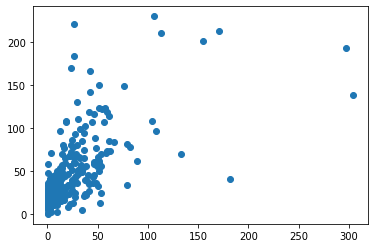

In [1068]:
r = agg2[agg2['start station id'] == 445]
print(pearsonr(r['count'], r['test_flows'])[0])
plt.scatter(r['count'], r['test_flows'])

0.8099498922928947


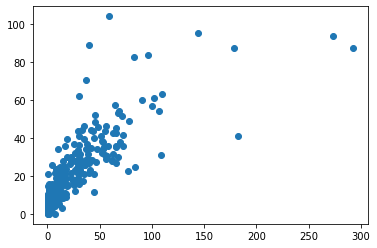

In [1069]:
r = agg2[agg2['end station id'] == 445]
print(pearsonr(r['count'], r['test_flows'])[0])
plt.scatter(r['count'], r['test_flows'])